In [1]:
import os

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"

from pathlib import Path

import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import torch
from dotenv import find_dotenv

from cvnets.yolo.v2 import utils
from cvnets.yolo.v2.dataset import VOCDataset
from cvnets.yolo.v2.net import YOLOv2

root = Path(find_dotenv(raise_error_if_not_found=True)).parent.absolute()
checkpoints = root.joinpath("src", "cvnets", "yolo", "v2", "checkpoints")

assert checkpoints.exists()

In [2]:
anchors = utils.load_anchor_bboxes(checkpoints.joinpath("anchors", "anchors_k5.npy"))
dataset = VOCDataset("~/Documents/Datasets/VOC/", anchors=anchors, imgsz=416, split="val", normalize=False)

model = YOLOv2(dataset.num_anchors, dataset.num_classes)
model.load_state_dict(
    torch.load(
        checkpoints.joinpath("run-2025-01-22-16-03-23", "yolov2-voc.pt"),
        map_location="cpu",
        weights_only=True,
    )
)
model = model.eval()

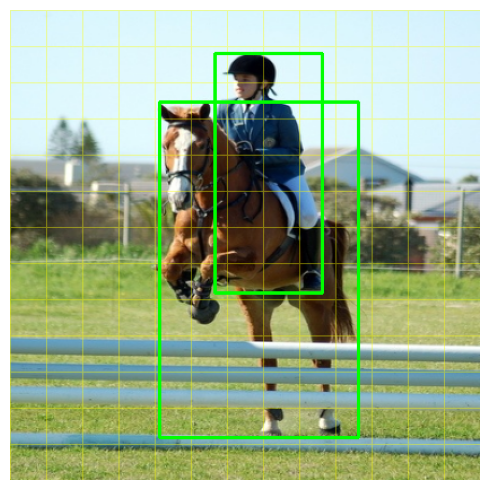

In [3]:
sample = dataset[123]

image = sample.image.permute(1, 2, 0).numpy().astype("uint8")
bboxes = sample.bboxes.numpy()
labels = sample.labels.numpy()

cell = dataset.imgsz // dataset.S
image_copy = image.copy()

for i in range(dataset.S):
    for j in range(dataset.S):
        cv.rectangle(image_copy, (j * cell, i * cell), ((j + 1) * cell, (i + 1) * cell), (255, 255, 0), 1)

cv.addWeighted(image, 0.6, image_copy, 0.4, 0, image_copy)

for bbox in bboxes:
    cv.rectangle(image_copy, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)

plt.figure(figsize=(5, 5), tight_layout=True)
plt.imshow(image_copy)
plt.axis("off")
plt.show()


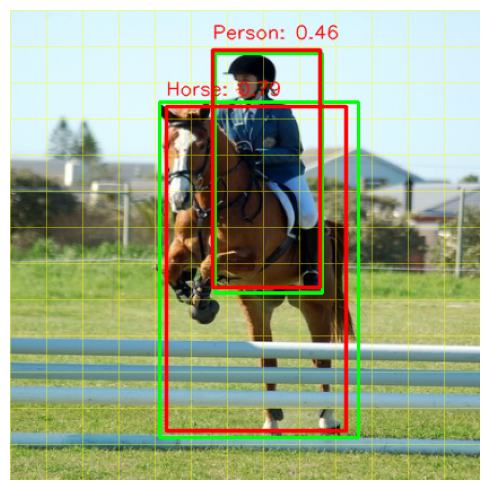

In [4]:
image_with_pred = image_copy.copy()

norm = A.Normalize()
normalized = norm(image=image)["image"]
normalized = torch.from_numpy(normalized).permute(2, 0, 1)

with torch.inference_mode():
    predictions = model(normalized.unsqueeze(0))

results = utils.postprocess_predictions(
    predictions=predictions,
    anchors=dataset.anchors,
    S=dataset.S,
    num_classes=dataset.num_classes,
    imgsz=(dataset.imgsz, dataset.imgsz),
    conf_thresh=0.2,
    nms_thresh=0.4,
)

r = results[0]
for xyxy, conf, label in zip(r.xyxys.numpy(), r.confs.numpy(), r.labels.numpy()):
    x1, y1, x2, y2 = xyxy.astype("int32")
    conf = conf.item()
    label = label.item()
    cv.putText(
        img=image_with_pred,
        text=f"{dataset.idx_to_class[label].title()}: {conf:.2f}",
        org=(x1, y1 - 10),
        fontFace=cv.FONT_HERSHEY_SIMPLEX,
        fontScale=0.55,
        color=(255, 0, 0),
        thickness=1,
        lineType=cv.LINE_AA,
    )
    cv.rectangle(image_with_pred, (x1, y1), (x2, y2), (255, 0, 0), 2, cv.LINE_AA)

plt.figure(figsize=(5, 5), tight_layout=True)
plt.imshow(image_with_pred)
plt.axis("off")
plt.show()